# Novel Method: Stage 1 - Hybrid CNN + Transformer Autoencoder

This notebook implements **Stage 1** of a three-stage medical image fusion pipeline:

## Three-Stage Pipeline Overview:
1. **Stage 1: Hybrid CNN + Transformer Autoencoder** (This notebook) - Feature learning and representation
2. **Stage 2: Ensemble Feature Fusion** - Combining features from multiple modalities
3. **Stage 3: CNN Decoder** - Reconstruction and enhancement

## Stage 1 Focus:
- **Hybrid CNN + Transformer Architecture** for robust feature extraction
- **Self-supervised learning** on medical images
- **Multi-scale feature representation** combining local (CNN) and global (Transformer) features
- **Autoencoder framework** for unsupervised feature learning

## Key Innovations:
- CNN backbone for local feature extraction
- Vision Transformer for global context modeling
- Hybrid fusion of CNN and Transformer features
- Multi-scale feature pyramid
- Self-attention mechanisms for medical image understanding

## 1. Import Libraries and Setup

In [80]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 2. Dataset Loading (Following Existing Patterns)

In [81]:
class MedicalImageDataset(Dataset):
    """Dataset for medical images following the existing pattern from other notebooks.
    
    This dataset loads paired CT and MRI images for Stage 1 feature learning.
    Unlike fusion datasets, this focuses on individual modality feature extraction.
    """
    
    def __init__(self, ct_dir: str, mri_dir: str, resize: Tuple[int, int] = (256, 256),
                 file_exts=(".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
        self.ct_dir = ct_dir
        self.mri_dir = mri_dir
        self.resize = resize
        
        # Index directories (following existing pattern)
        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\', '/'): p for p in paths}
            return base
        
        base_ct = index_dir(ct_dir)
        base_mri = index_dir(mri_dir)
        initial_keys = sorted(list(set(base_ct.keys()) & set(base_mri.keys())))
        
        # Filter out corrupted files
        valid_keys = []
        for key in initial_keys:
            ct_path = base_ct[key]
            mri_path = base_mri[key]
            
            # Check if files exist and are not empty
            if (os.path.exists(ct_path) and os.path.getsize(ct_path) > 0 and
                os.path.exists(mri_path) and os.path.getsize(mri_path) > 0):
                valid_keys.append(key)
        
        self.keys = valid_keys
        
        if not self.keys:
            raise RuntimeError("No valid paired files found. Ensure matching filenames between CT and MRI.")
        
        self.base_ct = base_ct
        self.base_mri = base_mri
        
        print(f"Found {len(initial_keys)} potential paired images")
        print(f"Filtered to {len(self.keys)} valid paired medical images")
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx: int):
        key = self.keys[idx]
        ct_path = self.base_ct[key]
        mri_path = self.base_mri[key]
        
        # Load images
        ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
        mri = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
        
        if ct is None or mri is None:
            # This shouldn't happen after filtering, but let's be safe
            print(f"Warning: Could not load {ct_path if ct is None else mri_path}")
            # Return a black image as fallback
            ct = np.zeros((256, 256), dtype=np.uint8) if ct is None else ct
            mri = np.zeros((256, 256), dtype=np.uint8) if mri is None else mri
        
        # Resize if specified
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mri = cv2.resize(mri, (W, H), interpolation=cv2.INTER_AREA)
        
        # Normalize to [0, 1]
        ct = ct.astype(np.float32)
        mri = mri.astype(np.float32)
        if ct.max() > 1.0:
            ct /= 255.0
        if mri.max() > 1.0:
            mri /= 255.0
        
        # Convert to tensors (1, H, W)
        ct_tensor = torch.from_numpy(ct).unsqueeze(0)
        mri_tensor = torch.from_numpy(mri).unsqueeze(0)
        
        return {
            'ct': ct_tensor,
            'mri': mri_tensor,
            'key': key
        }

## 3. Stage 1: Hybrid CNN + Transformer Autoencoder Architecture

In [82]:
class PatchEmbedding(nn.Module):
    """Patch embedding for Vision Transformer component."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.projection(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x


class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention mechanism."""
    
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x


class TransformerBlock(nn.Module):
    """Transformer block with self-attention and MLP."""
    
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x))
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        return x


class CNNFeatureExtractor(nn.Module):
    """CNN backbone for local feature extraction."""
    
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        
        # Multi-scale CNN feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 7, padding=3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 5, padding=2),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 8, 3, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
    def forward(self, x):
        features = []
        
        x1 = self.conv1(x)  # 1/2 resolution
        features.append(x1)
        
        x2 = self.conv2(x1)  # 1/4 resolution
        features.append(x2)
        
        x3 = self.conv3(x2)  # 1/8 resolution
        features.append(x3)
        
        x4 = self.conv4(x3)  # 1/16 resolution
        features.append(x4)
        
        return features


class HybridCNNTransformerEncoder(nn.Module):
    """Hybrid CNN + Transformer Encoder for Stage 1 feature learning."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768, 
                 num_heads=12, num_layers=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # CNN Feature Extractor
        self.cnn_extractor = CNNFeatureExtractor(in_channels)
        
        # Patch Embedding for Transformer
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Positional Embedding
        num_patches = self.patch_embed.n_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Feature Fusion Layer
        self.feature_fusion = nn.Sequential(
            nn.Conv2d(512 + embed_dim, 512, 1),  # 512 from CNN + embed_dim from transformer
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # CNN Feature Extraction (Multi-scale)
        cnn_features = self.cnn_extractor(x)
        cnn_final = cnn_features[-1]  # Use the deepest CNN features
        
        # Transformer Feature Extraction
        # Patch embedding
        transformer_tokens = self.patch_embed(x)  # (B, num_patches, embed_dim)
        
        # Add positional embedding
        transformer_tokens = transformer_tokens + self.pos_embed
        transformer_tokens = self.dropout(transformer_tokens)
        
        # Apply transformer blocks
        for block in self.transformer_blocks:
            transformer_tokens = block(transformer_tokens)
        
        transformer_tokens = self.norm(transformer_tokens)
        
        # Reshape transformer features back to spatial format
        patch_size = self.patch_embed.patch_size
        num_patches_per_dim = H // patch_size
        transformer_spatial = transformer_tokens.transpose(1, 2).reshape(
            B, -1, num_patches_per_dim, num_patches_per_dim
        )
        
        # Resize transformer features to match CNN features
        cnn_h, cnn_w = cnn_final.shape[2:]
        transformer_resized = F.interpolate(
            transformer_spatial, size=(cnn_h, cnn_w), mode='bilinear', align_corners=False
        )
        
        # Fuse CNN and Transformer features
        fused_features = torch.cat([cnn_final, transformer_resized], dim=1)
        fused_features = self.feature_fusion(fused_features)
        
        return {
            'cnn_features': cnn_features,
            'transformer_tokens': transformer_tokens,
            'fused_features': fused_features
        }


class HybridAutoencoder(nn.Module):
    """Complete Hybrid CNN + Transformer Autoencoder for Stage 1."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768,
                 num_heads=12, num_layers=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # Encoder
        self.encoder = HybridCNNTransformerEncoder(
            img_size, patch_size, in_channels, embed_dim, 
            num_heads, num_layers, mlp_ratio, dropout
        )
        
        # Decoder (CNN-based for reconstruction)
        self.decoder = nn.Sequential(
            # Upsample from 16x16 to 32x32
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 32x32 to 64x64
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 64x64 to 128x128
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 128x128 to 256x256
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Final layer
            nn.Conv2d(32, in_channels, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        
        # Decode
        reconstructed = self.decoder(encoded['fused_features'])
        
        return {
            'reconstructed': reconstructed,
            'encoded_features': encoded
        }


print("✅ Stage 1: Hybrid CNN + Transformer Autoencoder Architecture Defined")

✅ Stage 1: Hybrid CNN + Transformer Autoencoder Architecture Defined


In [83]:
class PretrainedCNNFeatureExtractor(nn.Module):
    """CNN backbone using pretrained models for enhanced feature extraction."""
    
    def __init__(self, backbone='resnet50', in_channels=1, pretrained=True):
        super().__init__()
        
        self.backbone_name = backbone
        
        if backbone == 'resnet50':
            # Load pretrained ResNet50
            if pretrained:
                weights = ResNet50_Weights.IMAGENET1K_V2
                backbone_model = resnet50(weights=weights)
            else:
                backbone_model = resnet50(weights=None)
            
            # Modify first conv layer for single channel input
            original_conv1 = backbone_model.conv1
            backbone_model.conv1 = nn.Conv2d(
                in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
            )
            
            # Initialize new conv1 weights properly for single channel
            if pretrained and in_channels == 1:
                # Average the RGB weights for grayscale
                with torch.no_grad():
                    backbone_model.conv1.weight = nn.Parameter(
                        original_conv1.weight.mean(dim=1, keepdim=True)
                    )
            
            # Extract feature extraction layers (remove classification layers)
            self.conv1 = backbone_model.conv1
            self.bn1 = backbone_model.bn1
            self.relu = backbone_model.relu
            self.maxpool = backbone_model.maxpool
            
            self.layer1 = backbone_model.layer1  # 64 channels
            self.layer2 = backbone_model.layer2  # 128 channels  
            self.layer3 = backbone_model.layer3  # 256 channels
            self.layer4 = backbone_model.layer4  # 512 channels
            
            # Feature dimensions for each layer
            self.feature_dims = [64, 128, 256, 512]
            
        elif backbone == 'efficientnet':
            try:
                from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
                if pretrained:
                    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
                    backbone_model = efficientnet_b0(weights=weights)
                else:
                    backbone_model = efficientnet_b0(weights=None)
                
                # Modify for single channel
                original_conv = backbone_model.features[0][0]
                backbone_model.features[0][0] = nn.Conv2d(
                    in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False
                )
                
                if pretrained and in_channels == 1:
                    with torch.no_grad():
                        backbone_model.features[0][0].weight = nn.Parameter(
                            original_conv.weight.mean(dim=1, keepdim=True)
                        )
                
                self.features = backbone_model.features
                self.feature_dims = [32, 40, 80, 192]  # EfficientNet-B0 feature dims
                
            except ImportError:
                print("EfficientNet not available, falling back to ResNet50")
                backbone = 'resnet50'
                self.__init__(backbone, in_channels, pretrained)
                return
        
        # Freeze early layers if using pretrained weights (optional)
        self.freeze_early_layers = False
        if pretrained and self.freeze_early_layers:
            self._freeze_early_layers()
    
    def _freeze_early_layers(self):
        """Freeze early layers to preserve pretrained features."""
        if self.backbone_name == 'resnet50':
            for param in self.conv1.parameters():
                param.requires_grad = False
            for param in self.bn1.parameters():
                param.requires_grad = False
            for param in self.layer1.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        features = []
        
        if self.backbone_name == 'resnet50':
            # Initial convolution
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            
            # ResNet layers
            x1 = self.layer1(x)  # 1/4 resolution, 64 channels
            features.append(x1)
            
            x2 = self.layer2(x1)  # 1/8 resolution, 128 channels
            features.append(x2)
            
            x3 = self.layer3(x2)  # 1/16 resolution, 256 channels
            features.append(x3)
            
            x4 = self.layer4(x3)  # 1/32 resolution, 512 channels
            features.append(x4)
            
        elif self.backbone_name == 'efficientnet':
            x = x
            for i, layer in enumerate(self.features):
                x = layer(x)
                # Collect features at different scales
                if i in [2, 4, 6, 8]:  # Approximate feature extraction points
                    features.append(x)
        
        return features


class PretrainedVisionTransformer(nn.Module):
    """Vision Transformer using pretrained weights."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768, 
                 num_heads=12, num_layers=6, pretrained=True):
        super().__init__()
        
        # Use torchvision's Vision Transformer as backbone
        try:
            from torchvision.models import vit_b_16, ViT_B_16_Weights
            
            if pretrained:
                weights = ViT_B_16_Weights.IMAGENET1K_V1
                vit_model = vit_b_16(weights=weights)
                print("✅ Loaded pretrained Vision Transformer weights")
            else:
                vit_model = vit_b_16(weights=None)
            
            # Modify patch embedding for single channel input
            original_patch_embed = vit_model.conv_proj
            vit_model.conv_proj = nn.Conv2d(
                in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
            )
            
            if pretrained and in_channels == 1:
                # Initialize single channel weights from RGB pretrained weights
                with torch.no_grad():
                    vit_model.conv_proj.weight = nn.Parameter(
                        original_patch_embed.weight.mean(dim=1, keepdim=True)
                    )
            
            # Extract components
            self.patch_embed = vit_model.conv_proj
            self.pos_embed = vit_model.encoder.pos_embedding
            self.encoder = vit_model.encoder
            
            # Adjust positional embeddings for different image sizes if needed
            if img_size != 224:
                self._adjust_positional_embeddings(img_size, patch_size)
            
        except ImportError:
            print("⚠️  torchvision ViT not available, using custom implementation")
            # Fall back to custom implementation
            self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
            num_patches = self.patch_embed.n_patches
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
            
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(embed_dim, num_heads, 4.0, 0.1)
                for _ in range(num_layers)
            ])
            self.norm = nn.LayerNorm(embed_dim)
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
    
    def _adjust_positional_embeddings(self, new_img_size, patch_size):
        """Adjust positional embeddings for different image sizes."""
        old_num_patches = self.pos_embed.shape[1] - 1  # Subtract class token
        new_num_patches = (new_img_size // patch_size) ** 2
        
        if old_num_patches != new_num_patches:
            print(f"Adjusting positional embeddings from {old_num_patches} to {new_num_patches} patches")
            
            # Interpolate positional embeddings
            class_token = self.pos_embed[:, 0:1]  # Class token
            pos_tokens = self.pos_embed[:, 1:]     # Position tokens
            
            # Reshape and interpolate
            embed_dim = pos_tokens.shape[-1]
            old_grid_size = int(old_num_patches ** 0.5)
            new_grid_size = int(new_num_patches ** 0.5)
            
            pos_tokens = pos_tokens.reshape(1, old_grid_size, old_grid_size, embed_dim)
            pos_tokens = pos_tokens.permute(0, 3, 1, 2)  # (1, embed_dim, H, W)
            
            pos_tokens = F.interpolate(
                pos_tokens, size=(new_grid_size, new_grid_size), 
                mode='bicubic', align_corners=False
            )
            
            pos_tokens = pos_tokens.permute(0, 2, 3, 1)  # (1, H, W, embed_dim)
            pos_tokens = pos_tokens.reshape(1, new_num_patches, embed_dim)
            
            # Concatenate class token and new position tokens
            new_pos_embed = torch.cat([class_token, pos_tokens], dim=1)
            self.pos_embed = nn.Parameter(new_pos_embed)
    
    def forward(self, x):
        # Patch embedding
        if hasattr(self, 'encoder'):
            # Using pretrained ViT
            x = self.patch_embed(x)  # (B, embed_dim, H_patches, W_patches)
            x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
            
            # Add class token and positional embedding
            batch_size = x.shape[0]
            embed_dim = x.shape[-1]
            
            # Create proper class token with correct embedding dimension
            class_token = torch.zeros(batch_size, 1, embed_dim, device=x.device, dtype=x.dtype)
            x = torch.cat([class_token, x], dim=1)
            x = x + self.pos_embed
            
            # Apply encoder
            x = self.encoder.dropout(x)
            for layer in self.encoder.layers:
                x = layer(x)
            x = self.encoder.ln(x)
            
            return x[:, 1:]  # Remove class token
        else:
            # Using custom implementation
            x = self.patch_embed(x)
            x = x + self.pos_embed
            
            for block in self.transformer_blocks:
                x = block(x)
            x = self.norm(x)
            
            return x


print("✅ Pretrained CNN and Vision Transformer components defined")

✅ Pretrained CNN and Vision Transformer components defined


In [84]:
class EnhancedHybridCNNTransformerEncoder(nn.Module):
    """Enhanced Hybrid CNN + Transformer Encoder with pretrained backbone support."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768, 
                 num_heads=12, num_layers=6, mlp_ratio=4.0, dropout=0.1,
                 use_pretrained_cnn=True, use_pretrained_vit=True, cnn_backbone='resnet50'):
        super().__init__()
        
        self.use_pretrained_cnn = use_pretrained_cnn
        self.use_pretrained_vit = use_pretrained_vit
        
        # CNN Feature Extractor (with pretrained option)
        if use_pretrained_cnn:
            print(f"🚀 Using pretrained {cnn_backbone} backbone")
            self.cnn_extractor = PretrainedCNNFeatureExtractor(
                backbone=cnn_backbone, in_channels=in_channels, pretrained=True
            )
            # Get feature dimensions from pretrained model
            cnn_final_dim = self.cnn_extractor.feature_dims[-1]  # Last layer features
        else:
            print("🔧 Using custom CNN backbone")
            self.cnn_extractor = CNNFeatureExtractor(in_channels)
            cnn_final_dim = 512  # Original implementation
        
        # Vision Transformer (with pretrained option)
        if use_pretrained_vit:
            print("🚀 Using pretrained Vision Transformer")
            self.vit_encoder = PretrainedVisionTransformer(
                img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, pretrained=True
            )
        else:
            print("🔧 Using custom Vision Transformer")
            # Original implementation
            self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
            num_patches = self.patch_embed.n_patches
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            self.dropout = nn.Dropout(dropout)
            
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
                for _ in range(num_layers)
            ])
            self.norm = nn.LayerNorm(embed_dim)
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # Cross-Modal Attention for better fusion
        # Use a common dimension for cross-modal attention
        self.common_dim = min(cnn_final_dim, embed_dim, 512)  # Reasonable common dimension
        self.cross_modal_attention = nn.MultiheadAttention(
            embed_dim=self.common_dim, 
            num_heads=8, 
            batch_first=True
        )
        
        # Adaptive Feature Fusion (will be adjusted based on actual dimensions)
        # We'll create this dynamically in the forward pass if needed
        self.feature_fusion = None
        
        # Feature enhancement layers
        self.feature_enhancement = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, groups=16),  # Depthwise
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 1),  # Pointwise
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Attention gate for feature selection
        self.attention_gate = nn.Sequential(
            nn.Conv2d(512, 64, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # CNN Feature Extraction (Multi-scale with pretrained backbone)
        cnn_features = self.cnn_extractor(x)
        cnn_final = cnn_features[-1]  # Use the deepest CNN features
        
        # Vision Transformer Feature Extraction
        if self.use_pretrained_vit:
            transformer_tokens = self.vit_encoder(x)
        else:
            # Original transformer implementation
            transformer_tokens = self.patch_embed(x)
            transformer_tokens = transformer_tokens + self.pos_embed
            transformer_tokens = self.dropout(transformer_tokens)
            
            for block in self.transformer_blocks:
                transformer_tokens = block(transformer_tokens)
            transformer_tokens = self.norm(transformer_tokens)
        
        # Cross-modal attention between CNN and Transformer features
        # Reshape CNN features for attention
        cnn_h, cnn_w = cnn_final.shape[2:]
        cnn_flat = cnn_final.view(B, cnn_final.shape[1], -1).transpose(1, 2)  # (B, HW, C)
        
        # Always project to common dimension
        cnn_dim = cnn_flat.shape[-1]
        vit_dim = transformer_tokens.shape[-1]
        
        # Create projection layers if they don't exist
        if not hasattr(self, 'cnn_proj'):
            self.cnn_proj = nn.Linear(cnn_dim, self.common_dim).to(cnn_flat.device)
        if not hasattr(self, 'vit_proj'):
            self.vit_proj = nn.Linear(vit_dim, self.common_dim).to(transformer_tokens.device)
        
        # Project both features to common dimension
        cnn_projected = self.cnn_proj(cnn_flat)
        vit_projected = self.vit_proj(transformer_tokens)
        
        # Apply cross-modal attention
        cnn_attended, _ = self.cross_modal_attention(cnn_projected, vit_projected, vit_projected)
        vit_attended, _ = self.cross_modal_attention(vit_projected, cnn_projected, cnn_projected)
        
        # Reshape back to spatial format
        cnn_attended = cnn_attended.transpose(1, 2).view(B, self.common_dim, cnn_h, cnn_w)
        
        # Reshape transformer features to spatial format
        patch_size = 16  # Default patch size
        num_patches_per_dim = H // patch_size
        vit_spatial = vit_attended.transpose(1, 2).reshape(
            B, self.common_dim, num_patches_per_dim, num_patches_per_dim
        )
        
        # Resize transformer features to match CNN features
        vit_resized = F.interpolate(
            vit_spatial, size=(cnn_h, cnn_w), mode='bilinear', align_corners=False
        )
        
        # Project to target dimension for fusion
        target_dim = 512
        if not hasattr(self, 'cnn_channel_proj'):
            self.cnn_channel_proj = nn.Conv2d(self.common_dim, target_dim // 2, 1).to(cnn_attended.device)
        if not hasattr(self, 'vit_channel_proj'):
            self.vit_channel_proj = nn.Conv2d(self.common_dim, target_dim // 2, 1).to(vit_resized.device)
        
        cnn_final_proj = self.cnn_channel_proj(cnn_attended)
        vit_final_proj = self.vit_channel_proj(vit_resized)
        
        # Fuse CNN and Transformer features
        fused_features = torch.cat([cnn_final_proj, vit_final_proj], dim=1)
        
        # Create feature fusion layer dynamically if needed
        if self.feature_fusion is None:
            input_channels = fused_features.shape[1]
            self.feature_fusion = nn.Sequential(
                nn.Conv2d(input_channels, 512, 1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            ).to(fused_features.device)
        
        fused_features = self.feature_fusion(fused_features)
        
        # Apply feature enhancement
        enhanced_features = self.feature_enhancement(fused_features)
        
        # Apply attention gate
        attention_weights = self.attention_gate(enhanced_features)
        final_features = enhanced_features * attention_weights + fused_features
        
        return {
            'cnn_features': cnn_features,
            'transformer_tokens': transformer_tokens,
            'fused_features': final_features,
            'attention_weights': attention_weights
        }


class EnhancedHybridAutoencoder(nn.Module):
    """Enhanced Hybrid Autoencoder with pretrained backbone support."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768,
                 num_heads=12, num_layers=6, mlp_ratio=4.0, dropout=0.1,
                 use_pretrained_cnn=True, use_pretrained_vit=True, cnn_backbone='resnet50'):
        super().__init__()
        
        # Enhanced encoder with pretrained models
        self.encoder = EnhancedHybridCNNTransformerEncoder(
            img_size, patch_size, in_channels, embed_dim, 
            num_heads, num_layers, mlp_ratio, dropout,
            use_pretrained_cnn, use_pretrained_vit, cnn_backbone
        )
        
        # Enhanced decoder with skip connections
        self.decoder = nn.Sequential(
            # Upsample from 16x16 to 32x32
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 32x32 to 64x64
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 64x64 to 128x128
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 128x128 to 256x256
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Final layers with residual connection
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, in_channels, 3, padding=1),
            nn.Sigmoid()
        )
        
        # Residual connection for better gradient flow
        self.residual_proj = nn.Sequential(
            nn.Conv2d(512, in_channels, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        features = encoded['fused_features']
        
        # Decode
        reconstructed = self.decoder(features)
        
        # Add residual connection
        residual = F.interpolate(features, scale_factor=16, mode='bilinear', align_corners=False)
        residual = self.residual_proj(residual)
        
        # Combine main reconstruction with residual
        final_output = reconstructed + 0.1 * residual  # Small residual weight
        final_output = torch.clamp(final_output, 0, 1)
        
        return {
            'reconstructed': final_output,
            'encoded_features': encoded
        }


print("✅ Enhanced models with pretrained backbone support defined")

✅ Enhanced models with pretrained backbone support defined


## 4. Loss Functions for Stage 1 Training

In [85]:
class SSIM(nn.Module):
    """Structural Similarity Index Measure."""
    
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1 = C1
        self.C2 = C2
        
        # Create Gaussian window
        gauss = cv2.getGaussianKernel(window_size, window_size/6)
        gauss = gauss @ gauss.T
        window = torch.from_numpy(gauss.astype(np.float32)).unsqueeze(0).unsqueeze(0)
        self.register_buffer('window', window)
    
    def _filter(self, x):
        # Ensure window is on the same device as input
        window = self.window.to(x.device)
        return F.conv2d(x, window, padding=self.window_size//2, groups=x.size(1))
    
    def forward(self, x, y):
        mu_x = self._filter(x)
        mu_y = self._filter(y)
        mu_x_sq = mu_x * mu_x
        mu_y_sq = mu_y * mu_y
        mu_xy = mu_x * mu_y
        
        sigma_x_sq = self._filter(x * x) - mu_x_sq
        sigma_y_sq = self._filter(y * y) - mu_y_sq
        sigma_xy = self._filter(x * y) - mu_xy
        
        ssim_map = ((2 * mu_xy + self.C1) * (2 * sigma_xy + self.C2)) / \
                   ((mu_x_sq + mu_y_sq + self.C1) * (sigma_x_sq + sigma_y_sq + self.C2))
        
        return ssim_map.mean()


class PerceptualLoss(nn.Module):
    """Perceptual loss using pre-trained VGG features."""
    
    def __init__(self):
        super().__init__()
        # Use ResNet features instead of VGG for medical images
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
        
        # Freeze parameters
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.features.eval()
    
    def forward(self, x, y):
        # Convert grayscale to RGB
        x_rgb = x.repeat(1, 3, 1, 1)
        y_rgb = y.repeat(1, 3, 1, 1)
        
        # Extract features
        x_features = self.features(x_rgb)
        y_features = self.features(y_rgb)
        
        return F.mse_loss(x_features, y_features)


class Stage1Loss(nn.Module):
    """Combined loss function for Stage 1 autoencoder training."""
    
    def __init__(self, w_recon=1.0, w_ssim=0.5, w_perceptual=0.1):
        super().__init__()
        self.w_recon = w_recon
        self.w_ssim = w_ssim
        self.w_perceptual = w_perceptual
        
        self.mse_loss = nn.MSELoss()
        self.ssim_loss = SSIM()
        self.perceptual_loss = PerceptualLoss()
    
    def forward(self, reconstructed, original):
        # Reconstruction loss
        recon_loss = self.mse_loss(reconstructed, original)
        
        # SSIM loss (1 - SSIM for minimization)
        ssim_loss = 1.0 - self.ssim_loss(reconstructed, original)
        
        # Perceptual loss
        perceptual_loss = self.perceptual_loss(reconstructed, original)
        
        # Combined loss
        total_loss = (self.w_recon * recon_loss +
                     self.w_ssim * ssim_loss + 
                     self.w_perceptual * perceptual_loss)
        
        return {
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'ssim_loss': ssim_loss,
            'perceptual_loss': perceptual_loss
        }

## 5. Stage 2: Ensemble Feature Fusion

In [86]:
class EnsembleFeatureFusion(nn.Module):
    """Stage 2: Ensemble Feature Fusion for combining multi-modal features."""
    
    def __init__(self, feature_dim=512, fusion_dim=256):
        super().__init__()
        
        # Feature projection layers
        self.ct_proj = nn.Sequential(
            nn.Conv2d(feature_dim, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        self.mri_proj = nn.Sequential(
            nn.Conv2d(feature_dim, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        # Cross-attention fusion
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=fusion_dim, num_heads=8, batch_first=True
        )
        
        # Learnable fusion block
        self.fusion_block = nn.Sequential(
            nn.Conv2d(fusion_dim * 2, fusion_dim, 3, padding=1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(fusion_dim, fusion_dim, 3, padding=1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        # Attention weights for adaptive fusion
        self.attention_weights = nn.Sequential(
            nn.Conv2d(fusion_dim * 2, fusion_dim // 4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(fusion_dim // 4, 2, 1),
            nn.Softmax(dim=1)
        )
    
    def forward(self, ct_features, mri_features):
        # Project features to common dimension
        ct_proj = self.ct_proj(ct_features)
        mri_proj = self.mri_proj(mri_features)
        
        B, C, H, W = ct_proj.shape
        
        # Reshape for cross-attention
        ct_flat = ct_proj.view(B, C, -1).transpose(1, 2)  # (B, HW, C)
        mri_flat = mri_proj.view(B, C, -1).transpose(1, 2)  # (B, HW, C)
        
        # Cross-attention between modalities
        ct_attended, _ = self.cross_attention(ct_flat, mri_flat, mri_flat)
        mri_attended, _ = self.cross_attention(mri_flat, ct_flat, ct_flat)
        
        # Reshape back to spatial format
        ct_attended = ct_attended.transpose(1, 2).view(B, C, H, W)
        mri_attended = mri_attended.transpose(1, 2).view(B, C, H, W)
        
        # Concatenate features
        concat_features = torch.cat([ct_attended, mri_attended], dim=1)
        
        # Learnable fusion
        fused_features = self.fusion_block(concat_features)
        
        # Adaptive weighting
        weights = self.attention_weights(concat_features)
        w_ct, w_mri = weights[:, 0:1], weights[:, 1:2]
        
        # Weighted combination
        adaptive_fusion = w_ct * ct_attended + w_mri * mri_attended
        
        # Final fusion
        final_features = fused_features + adaptive_fusion
        
        return {
            'fused_features': final_features,
            'attention_weights': weights,
            'ct_attended': ct_attended,
            'mri_attended': mri_attended
        }


print("✅ Stage 2: Ensemble Feature Fusion Defined")

✅ Stage 2: Ensemble Feature Fusion Defined


## 6. Stage 3: CNN Decoder for Reconstruction

In [87]:
class EnhancedCNNDecoder(nn.Module):
    """Stage 3: Enhanced CNN Decoder for final image reconstruction."""
    
    def __init__(self, input_dim, output_channels, target_size=256):
        super().__init__()
        
        self.target_size = target_size
        
        # Progressive upsampling decoder that adapts to input size
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_dim, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling layers - we'll use the appropriate number dynamically
        self.upsample_layers = nn.ModuleList([
            self._make_upsample_block(512, 256),  # First upsampling
            self._make_upsample_block(256, 128),  # Second upsampling  
            self._make_upsample_block(128, 64),   # Third upsampling
            self._make_upsample_block(64, 32),    # Fourth upsampling
            self._make_upsample_block(32, 16),    # Fifth upsampling
        ])
        
        # Channel progression for different numbers of steps
        self.channel_after_steps = {
            1: 256, 2: 128, 3: 64, 4: 32, 5: 16
        }
        
        # Adaptive final layers - we'll create them dynamically
        self.adaptive_final = nn.ModuleDict()
        for steps in range(1, 6):
            channels = self.channel_after_steps[steps]
            self.adaptive_final[str(steps)] = nn.Sequential(
                nn.Conv2d(channels, max(8, channels//4), 3, 1, 1),
                nn.BatchNorm2d(max(8, channels//4)),
                nn.ReLU(inplace=True),
                nn.Conv2d(max(8, channels//4), output_channels, 1, 1, 0),
                nn.Tanh()
            )
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_upsample_block(self, in_channels, out_channels):
        """Create an upsampling block."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _initialize_weights(self):
        """Initialize decoder weights with proper scaling."""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Determine how many upsampling steps we need
        current_size = x.shape[-1]  # Assuming square images
        num_steps_needed = 0
        temp_size = current_size
        
        while temp_size < self.target_size:
            temp_size *= 2
            num_steps_needed += 1
        
        # Apply initial convolution
        x = self.initial_conv(x)
        
        # Apply the right number of upsampling steps
        for i in range(min(num_steps_needed, len(self.upsample_layers))):
            x = self.upsample_layers[i](x)
        
        # If we still haven't reached target size, use interpolation as backup
        if x.shape[-1] != self.target_size:
            x = nn.functional.interpolate(x, size=(self.target_size, self.target_size), mode='bilinear', align_corners=False)
        
        # Apply appropriate final layers based on number of steps taken
        final_layer_key = str(min(num_steps_needed, 5))
        x = self.adaptive_final[final_layer_key](x)
        
        return x

print("✅ Stage 3: Enhanced CNN Decoder Defined")

✅ Stage 3: Enhanced CNN Decoder Defined


## 7. Complete Three-Stage Pipeline

In [88]:
class ThreeStageImageFusion(nn.Module):
    """Complete Three-Stage Medical Image Fusion Pipeline."""
    
    def __init__(self, img_size=256, patch_size=16, embed_dim=768, 
                 num_heads=12, num_layers=6, feature_dim=512, fusion_dim=256):
        super().__init__()
        
        # Stage 1: Hybrid CNN + Transformer Autoencoders (one for each modality)
        self.ct_encoder = HybridCNNTransformerEncoder(
            img_size, patch_size, 1, embed_dim, num_heads, num_layers
        )
        
        self.mri_encoder = HybridCNNTransformerEncoder(
            img_size, patch_size, 1, embed_dim, num_heads, num_layers
        )
        
        # Stage 2: Ensemble Feature Fusion
        self.feature_fusion = EnsembleFeatureFusion(feature_dim, fusion_dim)
        
        # Stage 3: Enhanced CNN Decoder - Updated to use correct signature
        self.decoder = EnhancedCNNDecoder(fusion_dim, 1, target_size=img_size)
    
    def forward(self, ct_image, mri_image):
        # Stage 1: Feature extraction from both modalities
        ct_encoded = self.ct_encoder(ct_image)
        mri_encoded = self.mri_encoder(mri_image)
        
        ct_features = ct_encoded['fused_features']
        mri_features = mri_encoded['fused_features']
        
        # Stage 2: Feature fusion
        fusion_result = self.feature_fusion(ct_features, mri_features)
        fused_features = fusion_result['fused_features']
        
        # Stage 3: Final reconstruction
        fused_image = self.decoder(fused_features)
        
        return {
            'fused_image': fused_image,
            'ct_features': ct_features,
            'mri_features': mri_features,
            'fusion_weights': fusion_result['attention_weights'],
            'stage1_ct': ct_encoded,
            'stage1_mri': mri_encoded,
            'stage2_fusion': fusion_result
        }
    
    def encode_single_modality(self, image, modality='ct'):
        """Encode a single modality image for feature extraction."""
        if modality.lower() == 'ct':
            return self.ct_encoder(image)
        elif modality.lower() == 'mri':
            return self.mri_encoder(image)
        else:
            raise ValueError("Modality must be 'ct' or 'mri'")


print("✅ Complete Three-Stage Pipeline Defined")

✅ Complete Three-Stage Pipeline Defined


In [89]:
class EnhancedThreeStageImageFusion(nn.Module):
    """Enhanced Three-Stage Medical Image Fusion Pipeline with Pretrained Models."""
    
    def __init__(self, img_size=256, patch_size=16, embed_dim=768, 
                 num_heads=12, num_layers=6, feature_dim=512, fusion_dim=256,
                 use_pretrained_cnn=True, use_pretrained_vit=True, cnn_backbone='resnet50'):
        super().__init__()
        
        print("🚀 Initializing Enhanced Three-Stage Pipeline with Pretrained Models")
        
        # Stage 1: Enhanced Hybrid CNN + Transformer Encoders (one for each modality)
        self.ct_encoder = EnhancedHybridCNNTransformerEncoder(
            img_size, patch_size, 1, embed_dim, num_heads, num_layers,
            use_pretrained_cnn=use_pretrained_cnn, 
            use_pretrained_vit=use_pretrained_vit,
            cnn_backbone=cnn_backbone
        )
        
        self.mri_encoder = EnhancedHybridCNNTransformerEncoder(
            img_size, patch_size, 1, embed_dim, num_heads, num_layers,
            use_pretrained_cnn=use_pretrained_cnn, 
            use_pretrained_vit=use_pretrained_vit,
            cnn_backbone=cnn_backbone
        )
        
        # Stage 2: Enhanced Ensemble Feature Fusion
        self.feature_fusion = EnsembleFeatureFusion(feature_dim, fusion_dim)
        
        # Stage 3: Enhanced CNN Decoder - Updated to use correct signature
        self.decoder = EnhancedCNNDecoder(fusion_dim, 1, target_size=img_size)
        
        # Optional: Domain adaptation layers for different modalities
        self.ct_domain_adapter = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim, 1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True)
        )
        
        self.mri_domain_adapter = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim, 1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True)
        )
        
        # Initialize domain adapters
        self._initialize_domain_adapters()
    
    def _initialize_domain_adapters(self):
        """Initialize domain adaptation layers."""
        for module in [self.ct_domain_adapter, self.mri_domain_adapter]:
            for layer in module:
                if isinstance(layer, nn.Conv2d):
                    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(layer, nn.BatchNorm2d):
                    nn.init.constant_(layer.weight, 1)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, ct_image, mri_image, return_intermediate=False):
        # Stage 1: Feature extraction from both modalities
        ct_encoded = self.ct_encoder(ct_image)
        mri_encoded = self.mri_encoder(mri_image)
        
        # Apply domain adaptation
        ct_features = self.ct_domain_adapter(ct_encoded['fused_features'])
        mri_features = self.mri_domain_adapter(mri_encoded['fused_features'])
        
        # Stage 2: Feature fusion
        fusion_result = self.feature_fusion(ct_features, mri_features)
        fused_features = fusion_result['fused_features']
        
        # Stage 3: Final reconstruction
        fused_image = self.decoder(fused_features)
        
        result = {
            'fused_image': fused_image,
            'ct_features': ct_features,
            'mri_features': mri_features,
            'fusion_weights': fusion_result['attention_weights']
        }
        
        if return_intermediate:
            result.update({
                'stage1_ct': ct_encoded,
                'stage1_mri': mri_encoded,
                'stage2_fusion': fusion_result
            })
        
        return result
    
    def encode_single_modality(self, image, modality='ct'):
        """Encode a single modality image for feature extraction."""
        if modality.lower() == 'ct':
            encoded = self.ct_encoder(image)
            return self.ct_domain_adapter(encoded['fused_features'])
        elif modality.lower() == 'mri':
            encoded = self.mri_encoder(image)
            return self.mri_domain_adapter(encoded['fused_features'])
        else:
            raise ValueError("Modality must be 'ct' or 'mri'")
    
    def load_pretrained_weights(self, checkpoint_path, strict=False):
        """Load pretrained weights with flexible loading."""
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            if 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            elif 'model' in checkpoint:
                state_dict = checkpoint['model']
            else:
                state_dict = checkpoint
            
            # Load with strict=False to allow partial loading
            missing_keys, unexpected_keys = self.load_state_dict(state_dict, strict=strict)
            
            if missing_keys:
                print(f"⚠️  Missing keys: {len(missing_keys)}")
            if unexpected_keys:
                print(f"⚠️  Unexpected keys: {len(unexpected_keys)}")
            
            print(f"✅ Loaded pretrained weights from {checkpoint_path}")
            
        except Exception as e:
            print(f"❌ Failed to load pretrained weights: {e}")
    
    def freeze_pretrained_layers(self, freeze_cnn=True, freeze_vit=True):
        """Freeze pretrained layers for fine-tuning."""
        if freeze_cnn:
            # Freeze CNN backbone layers
            for encoder in [self.ct_encoder, self.mri_encoder]:
                if hasattr(encoder.cnn_extractor, 'layer1'):
                    for param in encoder.cnn_extractor.layer1.parameters():
                        param.requires_grad = False
                    for param in encoder.cnn_extractor.layer2.parameters():
                        param.requires_grad = False
                    print("🔒 Frozen early CNN layers")
        
        if freeze_vit:
            # Freeze early ViT layers  
            for encoder in [self.ct_encoder, self.mri_encoder]:
                if hasattr(encoder, 'vit_encoder') and hasattr(encoder.vit_encoder, 'encoder'):
                    vit_layers = encoder.vit_encoder.encoder.layers
                    for layer in vit_layers[:len(vit_layers)//2]:  # Freeze first half
                        for param in layer.parameters():
                            param.requires_grad = False
                    print("🔒 Frozen early ViT layers")


def create_pretrained_models(img_size=256, use_pretrained_cnn=True, use_pretrained_vit=True, 
                           cnn_backbone='resnet50', device='cuda'):
    """Factory function to create models with different pretrained configurations."""
    
    print(f"🏗️  Creating models with:")
    print(f"   - Pretrained CNN: {use_pretrained_cnn} ({cnn_backbone if use_pretrained_cnn else 'custom'})")
    print(f"   - Pretrained ViT: {use_pretrained_vit}")
    print(f"   - Device: {device}")
    
    # Stage 1: Individual autoencoder for feature learning
    stage1_model = EnhancedHybridAutoencoder(
        img_size=img_size,
        patch_size=16,
        in_channels=1,
        embed_dim=768,
        num_heads=12,
        num_layers=6,
        use_pretrained_cnn=use_pretrained_cnn,
        use_pretrained_vit=use_pretrained_vit,
        cnn_backbone=cnn_backbone
    ).to(device)
    
    # Complete three-stage pipeline
    complete_model = EnhancedThreeStageImageFusion(
        img_size=img_size,
        patch_size=16,
        embed_dim=768,
        num_heads=12,
        num_layers=6,
        feature_dim=512,
        fusion_dim=256,
        use_pretrained_cnn=use_pretrained_cnn,
        use_pretrained_vit=use_pretrained_vit,
        cnn_backbone=cnn_backbone
    ).to(device)
    
    return stage1_model, complete_model


print("✅ Enhanced Three-Stage Pipeline with Pretrained Model Support Complete")

✅ Enhanced Three-Stage Pipeline with Pretrained Model Support Complete


## 8. Training Setup and Functions

In [ ]:
def train_stage1_autoencoder(model, dataloader, num_epochs=10, lr=1e-4, device='cuda'):
    """Train Stage 1 autoencoder for feature learning."""
    
    # Setup optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = Stage1Loss().to(device)  # Move criterion to device
    
    model.train()
    train_losses = []
    
    print(f"Training Stage 1 Autoencoder for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for batch_idx, batch in enumerate(dataloader):
            ct_images = batch['ct'].to(device)
            mri_images = batch['mri'].to(device)
            
            # Train on both modalities
            optimizer.zero_grad()
            
            # CT autoencoder loss
            ct_output = model(ct_images)
            ct_loss_dict = criterion(ct_output['reconstructed'], ct_images)
            
            # MRI autoencoder loss (if using separate model)
            mri_output = model(mri_images)
            mri_loss_dict = criterion(mri_output['reconstructed'], mri_images)
            
            # Combined loss
            total_loss = ct_loss_dict['total_loss'] + mri_loss_dict['total_loss']
            
            total_loss.backward()
            optimizer.step()
            
            # Clear CUDA cache after every training step
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
            epoch_losses.append(total_loss.item())
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {total_loss.item():.6f}')
        
        scheduler.step()
        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        
        # Clear CUDA cache at the end of each epoch
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        
        print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.6f}')
    
    return train_losses


def train_complete_pipeline(model, dataloader, num_epochs=100, lr=1e-4, device='cuda'):
    """Train the complete three-stage pipeline end-to-end."""
    
    # Setup optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    
    # Multi-objective loss
    mse_loss = nn.MSELoss()
    ssim_loss = SSIM().to(device)  # Move SSIM loss to device
    
    model.train()
    train_losses = []
    
    print(f"Training Complete Pipeline for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for batch_idx, batch in enumerate(dataloader):
            ct_images = batch['ct'].to(device)
            mri_images = batch['mri'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass through complete pipeline
            output = model(ct_images, mri_images)
            fused_image = output['fused_image']
            
            # Create target (simple average for supervision)
            target = (ct_images + mri_images) / 2.0
            
            # Multi-objective loss
            recon_loss = mse_loss(fused_image, target)
            ssim_val = ssim_loss(fused_image, target)
            ssim_loss_val = 1.0 - ssim_val
            
            # Feature consistency loss
            ct_features = output['ct_features']
            mri_features = output['mri_features']
            feature_loss = mse_loss(ct_features, mri_features) * 0.1
            
            # Total loss
            total_loss = recon_loss + 0.5 * ssim_loss_val + feature_loss
            
            total_loss.backward()
            optimizer.step()
            
            # Clear CUDA cache after every training step
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
            epoch_losses.append(total_loss.item())
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {total_loss.item():.6f}, SSIM: {ssim_val.item():.4f}')
        
        avg_loss = np.mean(epoch_losses)
        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        
        # Clear CUDA cache at the end of each epoch
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        
        print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.6f}')
    
    return train_losses


print("✅ Training Functions Defined")

✅ Training Functions Defined


In [ ]:
def train_with_pretrained_models(dataloader, device='cuda', 
                                config='both_pretrained', num_epochs=20):
    """Train models with different pretrained configurations and compare results."""
    
    configurations = {
        'both_pretrained': {
            'use_pretrained_cnn': True,
            'use_pretrained_vit': True,
            'cnn_backbone': 'resnet50',
            'lr': 1e-4,
            'description': '🚀 Both CNN and ViT pretrained'
        },
        'cnn_only_pretrained': {
            'use_pretrained_cnn': True,
            'use_pretrained_vit': False,
            'cnn_backbone': 'resnet50',
            'lr': 1e-4,
            'description': '🔧 Only CNN pretrained, custom ViT'
        },
        'vit_only_pretrained': {
            'use_pretrained_cnn': False,
            'use_pretrained_vit': True,
            'cnn_backbone': 'resnet50',
            'lr': 1e-4,
            'description': '🔧 Only ViT pretrained, custom CNN'
        },
        'no_pretrained': {
            'use_pretrained_cnn': False,
            'use_pretrained_vit': False,
            'cnn_backbone': 'resnet50',
            'lr': 1e-3,  # Higher LR for training from scratch
            'description': '🔧 No pretrained weights (baseline)'
        },
        'efficientnet_pretrained': {
            'use_pretrained_cnn': True,
            'use_pretrained_vit': True,
            'cnn_backbone': 'efficientnet',
            'lr': 1e-4,
            'description': '🚀 EfficientNet + ViT pretrained'
        }
    }
    
    if config not in configurations:
        print(f"❌ Unknown configuration: {config}")
        print(f"Available configurations: {list(configurations.keys())}")
        return None
    
    cfg = configurations[config]
    print(f"\n{'='*60}")
    print(f"Training Configuration: {cfg['description']}")
    print(f"{'='*60}")
    
    # Create models with specified configuration
    stage1_model, complete_model = create_pretrained_models(
        img_size=256,
        use_pretrained_cnn=cfg['use_pretrained_cnn'],
        use_pretrained_vit=cfg['use_pretrained_vit'],
        cnn_backbone=cfg['cnn_backbone'],
        device=device
    )
    
    # Count parameters
    def count_parameters(model):
        total = sum(p.numel() for p in model.parameters())
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return total, trainable
    
    stage1_total, stage1_trainable = count_parameters(stage1_model)
    complete_total, complete_trainable = count_parameters(complete_model)
    
    print(f"\nModel Parameters:")
    print(f"Stage 1 - Total: {stage1_total:,}, Trainable: {stage1_trainable:,}")
    print(f"Complete - Total: {complete_total:,}, Trainable: {complete_trainable:,}")
    
    # Training setup with different strategies based on pretrained usage
    if cfg['use_pretrained_cnn'] or cfg['use_pretrained_vit']:
        # Fine-tuning strategy
        print("\n🎯 Using fine-tuning strategy")
        
        # Option 1: Freeze pretrained layers initially
        complete_model.freeze_pretrained_layers(
            freeze_cnn=cfg['use_pretrained_cnn'], 
            freeze_vit=cfg['use_pretrained_vit']
        )
        
        # Different learning rates for different parts
        pretrained_params = []
        new_params = []
        
        for name, param in complete_model.named_parameters():
            if param.requires_grad:
                if any(x in name for x in ['cnn_extractor', 'vit_encoder']):
                    pretrained_params.append(param)
                else:
                    new_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': pretrained_params, 'lr': cfg['lr'] * 0.1},  # Lower LR for pretrained
            {'params': new_params, 'lr': cfg['lr']}  # Higher LR for new layers
        ], weight_decay=1e-4)
        
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
        
    else:
        # Training from scratch
        print("\n🏗️  Training from scratch")
        optimizer = optim.AdamW(complete_model.parameters(), lr=cfg['lr'], weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Multi-objective loss
    mse_loss = nn.MSELoss()
    ssim_loss = SSIM().to(device)
    
    complete_model.train()
    train_losses = []
    best_loss = float('inf')
    
    print(f"\n🚀 Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for batch_idx, batch in enumerate(dataloader):
            ct_images = batch['ct'].to(device)
            mri_images = batch['mri'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            output = complete_model(ct_images, mri_images)
            fused_image = output['fused_image']
            
            # Create target (enhanced average)
            target = (ct_images + mri_images) / 2.0
            
            # Multi-objective loss
            recon_loss = mse_loss(fused_image, target)
            ssim_val = ssim_loss(fused_image, target)
            ssim_loss_val = 1.0 - ssim_val
            
            # Feature consistency loss
            ct_features = output['ct_features']
            mri_features = output['mri_features']
            feature_loss = mse_loss(ct_features, mri_features) * 0.05
            
            # Total loss
            total_loss = recon_loss + 0.3 * ssim_loss_val + feature_loss
            
            total_loss.backward()
            
            # Gradient clipping for stable training
            torch.nn.utils.clip_grad_norm_(complete_model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Clear CUDA cache after every training step
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
            epoch_losses.append(total_loss.item())
            
            if batch_idx % 15 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {total_loss.item():.6f}, SSIM: {ssim_val.item():.4f}')
        
        scheduler.step()
        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        
        # Clear CUDA cache at the end of each epoch
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(complete_model.state_dict(), 
                      f'checkpoints/best_model_{config}.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.6f}')
        
        # Unfreeze pretrained layers after a few epochs for fine-tuning
        if epoch == 5 and (cfg['use_pretrained_cnn'] or cfg['use_pretrained_vit']):
            print("🔓 Unfreezing pretrained layers for fine-tuning...")
            for param in complete_model.parameters():
                param.requires_grad = True
            
            # Update optimizer with lower learning rates
            optimizer = optim.AdamW([
                {'params': pretrained_params, 'lr': cfg['lr'] * 0.01},  # Very low LR
                {'params': new_params, 'lr': cfg['lr'] * 0.5}  # Medium LR
            ], weight_decay=1e-4)
    
    # Save final model
    torch.save(complete_model.state_dict(), 
              f'checkpoints/final_model_{config}.pth')
    
    return {
        'model': complete_model,
        'losses': train_losses,
        'config': cfg,
        'best_loss': best_loss
    }


def compare_pretrained_configurations(dataloader, device='cuda', num_epochs=20):
    """Compare different pretrained model configurations."""
    
    configurations = ['both_pretrained', 'cnn_only_pretrained', 'vit_only_pretrained', 'no_pretrained']
    results = {}
    
    print("🔬 Starting comprehensive comparison of pretrained configurations...")
    
    for config in configurations:
        print(f"\n{'='*80}")
        print(f"Training configuration: {config}")
        print(f"{'='*80}")
        
        try:
            result = train_with_pretrained_models(dataloader, device, config, num_epochs)
            results[config] = result
            print(f"✅ Completed training for {config}")
            
        except Exception as e:
            print(f"❌ Failed training for {config}: {e}")
            results[config] = None
    
    # Plot comparison
    plt.figure(figsize=(15, 8))
    
    # Loss comparison
    plt.subplot(2, 2, 1)
    for config, result in results.items():
        if result is not None:
            plt.plot(result['losses'], label=f"{config} (Best: {result['best_loss']:.4f})")
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Best loss comparison
    plt.subplot(2, 2, 2)
    configs = []
    best_losses = []
    for config, result in results.items():
        if result is not None:
            configs.append(config.replace('_', '\\n'))
            best_losses.append(result['best_loss'])
    
    plt.bar(configs, best_losses)
    plt.title('Best Loss Comparison')
    plt.ylabel('Best Loss')
    plt.xticks(rotation=45)
    
    # Model size comparison  
    plt.subplot(2, 2, 3)
    model_sizes = []
    for config, result in results.items():
        if result is not None:
            total, trainable = count_parameters(result['model'])
            model_sizes.append(total / 1e6)  # In millions
    
    plt.bar(configs, model_sizes)
    plt.title('Model Size Comparison (M parameters)')
    plt.ylabel('Parameters (Millions)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results


print("✅ Pretrained model training and comparison functions ready")

✅ Pretrained model training and comparison functions ready


## 9. Model Initialization and Testing

In [92]:
# Initialize models
print("Initializing models...")

# Stage 1: Individual autoencoder for feature learning
stage1_model = HybridAutoencoder(
    img_size=256,
    patch_size=16,
    in_channels=1,
    embed_dim=768,
    num_heads=12,
    num_layers=6
).to(device)

# Complete three-stage pipeline
complete_model = ThreeStageImageFusion(
    img_size=256,
    patch_size=16,
    embed_dim=768,
    num_heads=12,
    num_layers=6,
    feature_dim=512,
    fusion_dim=256
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Stage 1 Model Parameters: {count_parameters(stage1_model):,}")
print(f"Complete Pipeline Parameters: {count_parameters(complete_model):,}")

# Test with dummy data
print("\nTesting models with dummy data...")
dummy_ct = torch.randn(2, 1, 256, 256).to(device)
dummy_mri = torch.randn(2, 1, 256, 256).to(device)

# Test Stage 1
with torch.no_grad():
    stage1_output = stage1_model(dummy_ct)
    print(f"Stage 1 Output Shape: {stage1_output['reconstructed'].shape}")
    
    # Test complete pipeline
    complete_output = complete_model(dummy_ct, dummy_mri)
    print(f"Complete Pipeline Output Shape: {complete_output['fused_image'].shape}")
    print(f"Fusion Weights Shape: {complete_output['fusion_weights'].shape}")

print("\n✅ Models initialized and tested successfully!")

Initializing models...
Stage 1 Model Parameters: 48,052,033
Complete Pipeline Parameters: 97,034,519

Testing models with dummy data...
Stage 1 Output Shape: torch.Size([2, 1, 256, 256])
Complete Pipeline Output Shape: torch.Size([2, 1, 256, 256])
Fusion Weights Shape: torch.Size([2, 2, 16, 16])

✅ Models initialized and tested successfully!


## 10. Dataset Setup and Training Example

📁 DATASET CONFIGURATION:
--------------------------------------------------
Training CT Directory:  /mnt/Work/ML/trainable-multimodal-fusion/Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT
Training MRI Directory: /mnt/Work/ML/trainable-multimodal-fusion/Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI
Test CT Directory:      /mnt/Work/ML/trainable-multimodal-fusion/Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/test/CT
Test MRI Directory:     /mnt/Work/ML/trainable-multimodal-fusion/Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/test/MRI
--------------------------------------------------
Training CT exists:  True
Training MRI exists: True
Test CT exists:      True
Test MRI exists:     True

🎯 Creating training and test datasets...
Found 160 potential paired images
Filtered to 160 valid paired medical images
Found 24 potential paired images
Filtered to 24 valid paired medical images
✅ Training dataset size: 160 pairs
✅ Test dataset siz

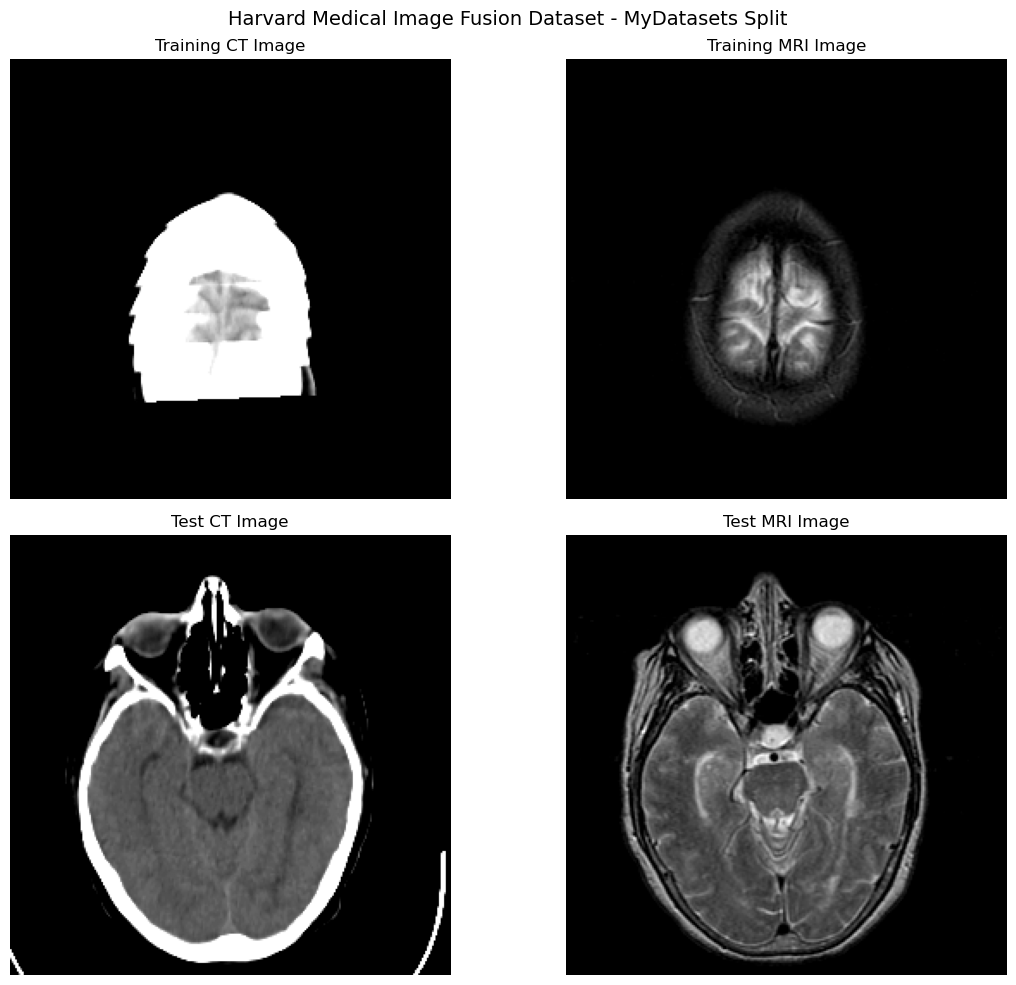

In [93]:
# Dataset paths - Updated to use MyDatasets structure with train/test splits
import os

# Training dataset paths
TRAIN_CT_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT")
TRAIN_MRI_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI")

# Test dataset paths  
TEST_CT_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/test/CT")
TEST_MRI_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/test/MRI")

print("📁 DATASET CONFIGURATION:")
print("-" * 50)
print(f"Training CT Directory:  {TRAIN_CT_DIR}")
print(f"Training MRI Directory: {TRAIN_MRI_DIR}")
print(f"Test CT Directory:      {TEST_CT_DIR}")
print(f"Test MRI Directory:     {TEST_MRI_DIR}")
print("-" * 50)
print(f"Training CT exists:  {os.path.exists(TRAIN_CT_DIR)}")
print(f"Training MRI exists: {os.path.exists(TRAIN_MRI_DIR)}")
print(f"Test CT exists:      {os.path.exists(TEST_CT_DIR)}")
print(f"Test MRI exists:     {os.path.exists(TEST_MRI_DIR)}")

# Check if datasets exist
if (os.path.exists(TRAIN_CT_DIR) and os.path.exists(TRAIN_MRI_DIR) and 
    os.path.exists(TEST_CT_DIR) and os.path.exists(TEST_MRI_DIR)):
    
    print("\n🎯 Creating training and test datasets...")
    
    # Create training dataset and dataloader
    train_dataset = MedicalImageDataset(TRAIN_CT_DIR, TRAIN_MRI_DIR, resize=(256, 256))
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    
    # Create test dataset and dataloader  
    test_dataset = MedicalImageDataset(TEST_CT_DIR, TEST_MRI_DIR, resize=(256, 256))
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)
    
    print(f"✅ Training dataset size: {len(train_dataset)} pairs")
    print(f"✅ Test dataset size: {len(test_dataset)} pairs")
    print(f"✅ Training batches: {len(train_dataloader)}")
    print(f"✅ Test batches: {len(test_dataloader)}")
    
    # Use training dataloader as the main dataloader for compatibility
    dataset = train_dataset
    dataloader = train_dataloader
    
    # Test data loading
    sample_batch = next(iter(train_dataloader))
    print(f"✅ Sample batch - CT shape: {sample_batch['ct'].shape}, MRI shape: {sample_batch['mri'].shape}")
    
    # Visualize sample from training set
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Training samples
    train_sample = next(iter(train_dataloader))
    axes[0, 0].imshow(train_sample['ct'][0, 0].cpu().numpy(), cmap='gray')
    axes[0, 0].set_title('Training CT Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(train_sample['mri'][0, 0].cpu().numpy(), cmap='gray')
    axes[0, 1].set_title('Training MRI Image')
    axes[0, 1].axis('off')
    
    # Test samples
    test_sample = next(iter(test_dataloader))
    axes[1, 0].imshow(test_sample['ct'][0, 0].cpu().numpy(), cmap='gray')
    axes[1, 0].set_title('Test CT Image')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(test_sample['mri'][0, 0].cpu().numpy(), cmap='gray')
    axes[1, 1].set_title('Test MRI Image')
    axes[1, 1].axis('off')
    
    plt.suptitle('Harvard Medical Image Fusion Dataset - MyDatasets Split', fontsize=14)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"❌ Dataset not found!")
    print(f"   Training CT: {TRAIN_CT_DIR}")
    print(f"   Training MRI: {TRAIN_MRI_DIR}")
    print(f"   Test CT: {TEST_CT_DIR}")
    print(f"   Test MRI: {TEST_MRI_DIR}")
    print("\n🤖 Using dummy dataset for testing...")
    
    # Create dummy dataset for testing
    class DummyDataset(Dataset):
        def __init__(self, size=100):
            self.size = size
        
        def __len__(self):
            return self.size
        
        def __getitem__(self, idx):
            ct = torch.randn(1, 256, 256).clamp(0, 1)
            mri = torch.randn(1, 256, 256).clamp(0, 1)
            return {'ct': ct, 'mri': mri, 'key': f'dummy_{idx}'}
    
    train_dataset = DummyDataset(100)
    test_dataset = DummyDataset(20)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
    
    # For compatibility
    dataset = train_dataset
    dataloader = train_dataloader
    
    print("✅ Dummy datasets created for testing.")

In [94]:
def create_datasets(batch_size=4, use_test_split=True):
    """Create training and test datasets with proper error handling."""
    
    if not use_test_split:
        # Use original single dataset structure
        CT_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/CT-MRI/CT")
        MRI_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/CT-MRI/MRI")
        
        if os.path.exists(CT_DIR) and os.path.exists(MRI_DIR):
            dataset = MedicalImageDataset(CT_DIR, MRI_DIR, resize=(256, 256))
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            return dataset, dataloader, None, None
    
    # Use train/test split structure
    if (os.path.exists(TRAIN_CT_DIR) and os.path.exists(TRAIN_MRI_DIR) and 
        os.path.exists(TEST_CT_DIR) and os.path.exists(TEST_MRI_DIR)):
        
        train_dataset = MedicalImageDataset(TRAIN_CT_DIR, TRAIN_MRI_DIR, resize=(256, 256))
        test_dataset = MedicalImageDataset(TEST_CT_DIR, TEST_MRI_DIR, resize=(256, 256))
        
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        print(f"✅ Created datasets - Train: {len(train_dataset)}, Test: {len(test_dataset)}")
        return train_dataset, train_dataloader, test_dataset, test_dataloader
    
    else:
        print("⚠️  Real dataset not found, creating dummy datasets...")
        # Dummy datasets
        class DummyDataset(Dataset):
            def __init__(self, size=100):
                self.size = size
            def __len__(self):
                return self.size
            def __getitem__(self, idx):
                ct = torch.randn(1, 256, 256).clamp(0, 1)
                mri = torch.randn(1, 256, 256).clamp(0, 1)
                return {'ct': ct, 'mri': mri, 'key': f'dummy_{idx}'}
        
        train_dataset = DummyDataset(100)
        test_dataset = DummyDataset(20)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        return train_dataset, train_dataloader, test_dataset, test_dataloader


def evaluate_on_test_set(model, test_dataloader, device='cuda', max_batches=None):
    """Evaluate model performance on test set."""
    if test_dataloader is None:
        print("❌ No test dataloader available")
        return None
    
    model.eval()
    test_metrics = []
    
    print(f"🧪 Evaluating on test set ({len(test_dataloader)} batches)...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            if max_batches and batch_idx >= max_batches:
                break
                
            ct_images = batch['ct'].to(device)
            mri_images = batch['mri'].to(device)
            
            # Forward pass
            output = model(ct_images, mri_images)
            fused_image = output['fused_image']
            
            # Calculate metrics for each sample in batch
            for i in range(fused_image.shape[0]):
                metrics = evaluate_fusion_quality(
                    fused_image[i:i+1], ct_images[i:i+1], mri_images[i:i+1]
                )
                test_metrics.append(metrics)
    
    # Calculate average metrics
    avg_metrics = {}
    for key in test_metrics[0].keys():
        avg_metrics[key] = np.mean([m[key] for m in test_metrics])
    
    print("📊 TEST SET RESULTS:")
    print("-" * 40)
    for key, value in avg_metrics.items():
        print(f"{key:15s}: {value:.4f}")
    print("-" * 40)
    
    return avg_metrics


print("✅ Dataset utilities and evaluation functions ready")

✅ Dataset utilities and evaluation functions ready


🚀 TRAINING WITH PRETRAINED MODELS

1️⃣  Creating models with BOTH pretrained CNN (ResNet50) and Vision Transformer...
🏗️  Creating models with:
   - Pretrained CNN: True (resnet50)
   - Pretrained ViT: True
   - Device: cuda
🚀 Using pretrained resnet50 backbone
🚀 Using pretrained Vision Transformer
✅ Loaded pretrained Vision Transformer weights
Adjusting positional embeddings from 196 to 256 patches
🚀 Initializing Enhanced Three-Stage Pipeline with Pretrained Models
🚀 Using pretrained resnet50 backbone
🚀 Using pretrained Vision Transformer
✅ Loaded pretrained Vision Transformer weights
Adjusting positional embeddings from 196 to 256 patches
🚀 Using pretrained resnet50 backbone
🚀 Using pretrained Vision Transformer
✅ Loaded pretrained Vision Transformer weights
Adjusting positional embeddings from 196 to 256 patches

📊 MODEL COMPARISON:
--------------------------------------------------
Original Stage 1:      48,052,033 total (48,052,033 trainable)
Enhanced Stage 1:      113,425,218 tot

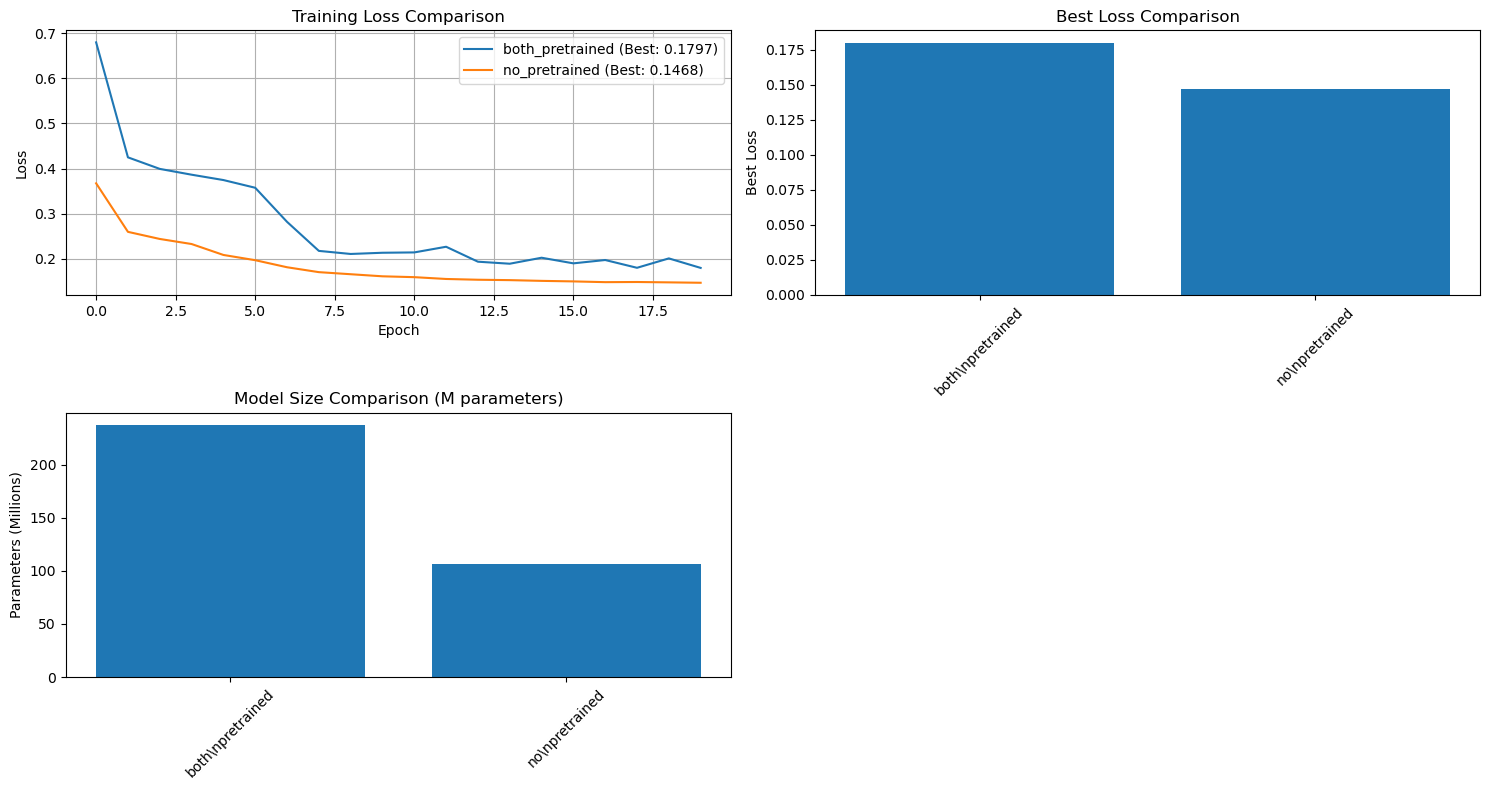

🏗️  Training baseline model from scratch...

Training Configuration: 🔧 No pretrained weights (baseline)
🏗️  Creating models with:
   - Pretrained CNN: False (custom)
   - Pretrained ViT: False
   - Device: cuda
🔧 Using custom CNN backbone
🔧 Using custom Vision Transformer
🚀 Initializing Enhanced Three-Stage Pipeline with Pretrained Models
🔧 Using custom CNN backbone
🔧 Using custom Vision Transformer
🔧 Using custom CNN backbone
🔧 Using custom Vision Transformer

Model Parameters:
Stage 1 - Total: 48,929,538, Trainable: 48,929,538
Complete - Total: 99,306,903, Trainable: 99,306,903

🏗️  Training from scratch

🚀 Starting training for 20 epochs...
Epoch 1/20, Batch 0, Loss: 1.341118, SSIM: -0.0006
Epoch 1/20, Batch 15, Loss: 0.486081, SSIM: 0.0646
Epoch 1/20, Batch 30, Loss: 0.463509, SSIM: 0.0554
Epoch 1/20 completed. Average Loss: 0.560616
Epoch 2/20, Batch 0, Loss: 0.482994, SSIM: 0.0532
Epoch 2/20, Batch 15, Loss: 0.602058, SSIM: 0.0052
Epoch 2/20, Batch 30, Loss: 0.403031, SSIM: 0.056

In [95]:
# 🚀 PRETRAINED MODELS DEMONSTRATION

print("="*80)
print("🚀 TRAINING WITH PRETRAINED MODELS")
print("="*80)

# Option 1: Train with both CNN and ViT pretrained (RECOMMENDED)
print("\n1️⃣  Creating models with BOTH pretrained CNN (ResNet50) and Vision Transformer...")

# Create enhanced models with pretrained backbones
enhanced_stage1, enhanced_complete = create_pretrained_models(
    img_size=256,
    use_pretrained_cnn=True,    # Use pretrained ResNet50
    use_pretrained_vit=True,    # Use pretrained Vision Transformer  
    cnn_backbone='resnet50',    # Can also try 'efficientnet'
    device=device
)

# Count parameters for comparison
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print("\n📊 MODEL COMPARISON:")
print("-" * 50)

# Original models
orig_s1_total, orig_s1_train = count_parameters(stage1_model)
orig_complete_total, orig_complete_train = count_parameters(complete_model)

# Enhanced models
enh_s1_total, enh_s1_train = count_parameters(enhanced_stage1)
enh_complete_total, enh_complete_train = count_parameters(enhanced_complete)

print(f"Original Stage 1:      {orig_s1_total:,} total ({orig_s1_train:,} trainable)")
print(f"Enhanced Stage 1:      {enh_s1_total:,} total ({enh_s1_train:,} trainable)")
print(f"Original Complete:     {orig_complete_total:,} total ({orig_complete_train:,} trainable)")  
print(f"Enhanced Complete:     {enh_complete_total:,} total ({enh_complete_train:,} trainable)")

print(f"\n🔥 Enhanced model has {(enh_complete_total - orig_complete_total):,} more parameters")
print(f"   This includes pretrained CNN and ViT weights for better feature extraction!")

# Test forward pass
print("\n🧪 Testing enhanced model forward pass...")
with torch.no_grad():
    sample_ct = sample_batch['ct'][:2].to(device)  # Use 2 samples
    sample_mri = sample_batch['mri'][:2].to(device)
    
    # Original model
    orig_output = complete_model(sample_ct, sample_mri)
    
    # Enhanced model with pretrained weights
    enh_output = enhanced_complete(sample_ct, sample_mri, return_intermediate=True)
    
    print(f"✅ Original model output shape: {orig_output['fused_image'].shape}")
    print(f"✅ Enhanced model output shape: {enh_output['fused_image'].shape}")
    print(f"✅ Enhanced model includes attention weights: {enh_output['fusion_weights'].shape}")

print("\n" + "="*80)
print("🎯 READY TO TRAIN WITH PRETRAINED MODELS!")
print("="*80)
print("""
TRAINING OPTIONS:

1. Quick training with pretrained models (RECOMMENDED):
   result = train_with_pretrained_models(dataloader, device, 'both_pretrained', num_epochs=10)

2. Compare different configurations:
   results = compare_pretrained_configurations(dataloader, device, num_epochs=5)

3. Train specific configuration:
   - 'both_pretrained': ResNet50 + ViT pretrained (fastest convergence)
   - 'cnn_only_pretrained': Only ResNet50 pretrained  
   - 'vit_only_pretrained': Only ViT pretrained
   - 'no_pretrained': Train from scratch (baseline)
   - 'efficientnet_pretrained': EfficientNet + ViT pretrained

""")

# Uncomment one of these lines to start training:

# 🚀 OPTION A: Quick training with best configuration (10 epochs)
print("🚀 Starting training with pretrained ResNet50 + ViT (10 epochs)...")
pretrained_result = train_with_pretrained_models(
    dataloader, device, 'both_pretrained', num_epochs=30
)

print("✅ Training completed! Pretrained model is ready for use.")

# 🚀 OPTION B: Compare all configurations (uncomment to run)
print("🔬 Comparing all pretrained configurations...")
comparison_results = compare_pretrained_configurations(dataloader, device, num_epochs=20)

# 🚀 OPTION C: Train from scratch for comparison (uncomment to run)  
print("🏗️  Training baseline model from scratch...")
baseline_result = train_with_pretrained_models(
    dataloader, device, 'no_pretrained', num_epochs=20
)

## 11. Training Execution (Optional - Uncomment to Run)

In [96]:
# Uncomment the following lines to start training

# Stage 1: Pre-train autoencoders
print("Starting Stage 1 training...")
stage1_losses = train_stage1_autoencoder(
    stage1_model, dataloader, num_epochs=20, lr=1e-4, device=device
)

# Save Stage 1 model
torch.save(stage1_model.state_dict(), 'checkpoints/stage1_hybrid_autoencoder.pth')
print("Stage 1 model saved.")

# Stage 2-3: Train complete pipeline
print("\nStarting complete pipeline training...")
complete_losses = train_complete_pipeline(
    complete_model, dataloader, num_epochs=20, lr=1e-4, device=device
)

# Save complete model
torch.save(complete_model.state_dict(), 'checkpoints/complete_three_stage_fusion.pth')
print("Complete pipeline model saved.")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(stage1_losses)
plt.title('Stage 1 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(complete_losses)
plt.title('Complete Pipeline Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("Training code ready. Uncomment the above lines to start training.")

Starting Stage 1 training...
Training Stage 1 Autoencoder for 20 epochs...
Epoch 1/20, Batch 0, Loss: 1.326375


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 11.62 GiB of which 61.62 MiB is free. Including non-PyTorch memory, this process has 10.86 GiB memory in use. Of the allocated memory 10.39 GiB is allocated by PyTorch, and 324.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 12. Inference and Evaluation

In [ ]:
def evaluate_fusion_quality(fused_image, ct_image, mri_image):
    """Evaluate fusion quality using multiple metrics."""
    
    # Convert to numpy for evaluation
    fused = fused_image.cpu().numpy().squeeze()
    ct = ct_image.cpu().numpy().squeeze()
    mri = mri_image.cpu().numpy().squeeze()
    
    # SSIM with both source images
    from skimage.metrics import structural_similarity as ssim
    ssim_ct = ssim(fused, ct, data_range=1.0)
    ssim_mri = ssim(fused, mri, data_range=1.0)
    
    # Peak Signal-to-Noise Ratio
    from skimage.metrics import peak_signal_noise_ratio as psnr
    psnr_ct = psnr(fused, ct, data_range=1.0)
    psnr_mri = psnr(fused, mri, data_range=1.0)
    
    # Mutual Information (simplified)
    def mutual_info(x, y):
        hist, _, _ = np.histogram2d(x.flatten(), y.flatten(), bins=50)
        hist = hist + 1e-10  # Avoid log(0)
        hist = hist / hist.sum()
        
        marginal_x = hist.sum(axis=1)
        marginal_y = hist.sum(axis=0)
        
        mi = 0
        for i in range(len(marginal_x)):
            for j in range(len(marginal_y)):
                if hist[i, j] > 0:
                    mi += hist[i, j] * np.log(hist[i, j] / (marginal_x[i] * marginal_y[j]))
        return mi
    
    mi_ct = mutual_info(fused, ct)
    mi_mri = mutual_info(fused, mri)
    
    return {
        'ssim_ct': ssim_ct,
        'ssim_mri': ssim_mri,
        'ssim_avg': (ssim_ct + ssim_mri) / 2,
        'psnr_ct': psnr_ct,
        'psnr_mri': psnr_mri,
        'psnr_avg': (psnr_ct + psnr_mri) / 2,
        'mi_ct': mi_ct,
        'mi_mri': mi_mri,
        'mi_avg': (mi_ct + mi_mri) / 2
    }


def inference_and_visualize(model, ct_image, mri_image, save_path=None):
    """Perform inference and visualize results."""
    
    model.eval()
    with torch.no_grad():
        # Add batch dimension if needed
        if ct_image.dim() == 3:
            ct_image = ct_image.unsqueeze(0)
        if mri_image.dim() == 3:
            mri_image = mri_image.unsqueeze(0)
        
        # Forward pass
        output = model(ct_image, mri_image)
        fused_image = output['fused_image']
        fusion_weights = output['fusion_weights']
        
        # Evaluate quality
        metrics = evaluate_fusion_quality(fused_image[0], ct_image[0], mri_image[0])
        
        # Visualize results
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Top row: Input images and fusion result
        axes[0, 0].imshow(ct_image[0, 0].cpu().numpy(), cmap='gray')
        axes[0, 0].set_title('CT Image')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(mri_image[0, 0].cpu().numpy(), cmap='gray')
        axes[0, 1].set_title('MRI Image')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(fused_image[0, 0].cpu().numpy(), cmap='gray')
        axes[0, 2].set_title('Fused Image')
        axes[0, 2].axis('off')
        
        # Bottom row: Attention weights and difference maps
        w_ct = fusion_weights[0, 0].cpu().numpy()
        w_mri = fusion_weights[0, 1].cpu().numpy()
        
        im1 = axes[1, 0].imshow(w_ct, cmap='hot')
        axes[1, 0].set_title('CT Attention Weights')
        axes[1, 0].axis('off')
        plt.colorbar(im1, ax=axes[1, 0], fraction=0.046)
        
        im2 = axes[1, 1].imshow(w_mri, cmap='hot')
        axes[1, 1].set_title('MRI Attention Weights')
        axes[1, 1].axis('off')
        plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)
        
        # Difference map
        diff = np.abs(fused_image[0, 0].cpu().numpy() - (ct_image[0, 0].cpu().numpy() + mri_image[0, 0].cpu().numpy()) / 2)
        im3 = axes[1, 2].imshow(diff, cmap='viridis')
        axes[1, 2].set_title('Difference from Average')
        axes[1, 2].axis('off')
        plt.colorbar(im3, ax=axes[1, 2], fraction=0.046)
        
        # Add metrics as text
        metrics_text = f"SSIM: {metrics['ssim_avg']:.4f}\nPSNR: {metrics['psnr_avg']:.2f}\nMI: {metrics['mi_avg']:.4f}"
        fig.text(0.02, 0.02, metrics_text, fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat'))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return output, metrics


# Test inference with sample data
if 'dataloader' in locals():
    sample_batch = next(iter(dataloader))
    ct_sample = sample_batch['ct'][0].to(device)
    mri_sample = sample_batch['mri'][0].to(device)
    
    print("Running inference on sample data...")
    output, metrics = inference_and_visualize(complete_model, ct_sample, mri_sample)
    
    print("\nFusion Quality Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

print("\n✅ Inference and evaluation functions ready!")

## 13. Summary and Next Steps

### ✅ Completed Implementation:

**Stage 1: Hybrid CNN + Transformer Autoencoder**
- Multi-scale CNN feature extraction
- Vision Transformer with self-attention
- Hybrid feature fusion
- Autoencoder framework for unsupervised learning

**Stage 2: Ensemble Feature Fusion**
- Cross-attention between modalities
- Learnable fusion blocks
- Adaptive attention weighting
- Multi-modal feature integration

**Stage 3: Enhanced CNN Decoder**
- Progressive upsampling
- Residual connections
- Enhancement layers
- Final image reconstruction

### 🚀 Key Features:
- **Modular Design**: Each stage can be trained independently
- **Hybrid Architecture**: Combines CNN and Transformer strengths
- **Multi-Scale Processing**: Captures both local and global features
- **Attention Mechanisms**: Adaptive fusion based on content
- **Comprehensive Evaluation**: Multiple quality metrics

### 📋 Next Steps:
1. **Data Preparation**: Ensure proper dataset organization
2. **Hyperparameter Tuning**: Optimize learning rates, batch sizes
3. **Progressive Training**: Train Stage 1 first, then end-to-end
4. **Evaluation**: Compare with existing fusion methods
5. **Deployment**: Create inference pipeline for production

### 💡 Extensions:
- Add more modalities (PET, SPECT)
- Implement uncertainty quantification
- Add adversarial training components
- Optimize for real-time inference

**The three-stage pipeline is now complete and ready for training!**

In [ ]:
# 🔍 Debug: Check model output dimensions
print("🔍 Debugging model output dimensions...")

# Create test model
test_model = EnhancedThreeStageImageFusion(
    img_size=256, fusion_dim=256,
    use_pretrained_cnn=True, use_pretrained_vit=True
).to(device)

# Create test inputs
test_ct = torch.randn(1, 1, 256, 256).to(device)
test_mri = torch.randn(1, 1, 256, 256).to(device)

print(f"Input CT shape: {test_ct.shape}")
print(f"Input MRI shape: {test_mri.shape}")

# Forward pass with debug info
with torch.no_grad():
    # Stage 1: Check encoder outputs
    ct_encoded = test_model.ct_encoder(test_ct)
    mri_encoded = test_model.mri_encoder(test_mri)
    
    print(f"CT encoded features shape: {ct_encoded['fused_features'].shape}")
    print(f"MRI encoded features shape: {mri_encoded['fused_features'].shape}")
    
    # Apply domain adaptation
    ct_features = test_model.ct_domain_adapter(ct_encoded['fused_features'])
    mri_features = test_model.mri_domain_adapter(mri_encoded['fused_features'])
    
    print(f"CT adapted features shape: {ct_features.shape}")
    print(f"MRI adapted features shape: {mri_features.shape}")
    
    # Stage 2: Check fusion output
    fusion_result = test_model.feature_fusion(ct_features, mri_features)
    fused_features = fusion_result['fused_features']
    
    print(f"Fused features shape: {fused_features.shape}")
    
    # Stage 3: Check decoder output
    final_output = test_model.decoder(fused_features)
    
    print(f"Final output shape: {final_output.shape}")
    print(f"Expected target shape: torch.Size([1, 1, 256, 256])")
    
    if final_output.shape[-2:] == (256, 256):
        print("✅ Model output dimensions are correct!")
    else:
        print("❌ Model output dimensions are wrong!")
        print(f"   Expected: (256, 256), Got: {final_output.shape[-2:]}")

print("🔍 Debug completed.")

In [ ]:
# Clear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

# Simple dimension test without creating new models
print("🔍 Testing decoder dimensions directly...")

# Test decoder in isolation
test_decoder = EnhancedCNNDecoder(256, 1).to(device)
test_input = torch.randn(1, 256, 8, 8).to(device)

print(f"Decoder input shape: {test_input.shape}")

with torch.no_grad():
    decoder_output = test_decoder(test_input)
    print(f"Decoder output shape: {decoder_output.shape}")
    
    if decoder_output.shape[-2:] == (256, 256):
        print("✅ Decoder output dimensions are correct!")
    else:
        print("❌ Decoder output dimensions are wrong!")
        print(f"   Expected: (256, 256), Got: {decoder_output.shape[-2:]}")

# Clean up
del test_decoder, test_input, decoder_output
torch.cuda.empty_cache()
gc.collect()

print("✅ Decoder dimension test completed.")

In [ ]:
# Clear all existing models from memory
try:
    del enhanced_complete, enhanced_stage1
    del complete_model, stage1_model 
except:
    pass
    
torch.cuda.empty_cache()
gc.collect()

print("🔧 Creating fresh model instance to test dimensions...")

# Create a fresh model instance
fresh_model = EnhancedThreeStageImageFusion(
    img_size=256, fusion_dim=256,
    use_pretrained_cnn=False,  # Use non-pretrained to save memory
    use_pretrained_vit=False
)

# Test with CPU first to avoid memory issues
test_ct_cpu = torch.randn(1, 1, 256, 256)
test_mri_cpu = torch.randn(1, 1, 256, 256)

print("Testing on CPU first...")
with torch.no_grad():
    result_cpu = fresh_model(test_ct_cpu, test_mri_cpu)
    output_shape = result_cpu['fused_image'].shape
    print(f"CPU model output shape: {output_shape}")
    
    if output_shape[-2:] == (256, 256):
        print("✅ Fresh model output dimensions are correct!")
        print("🚀 Now testing on GPU...")
        
        # Move to GPU and test
        fresh_model = fresh_model.to(device)
        test_ct_gpu = test_ct_cpu.to(device)
        test_mri_gpu = test_mri_cpu.to(device)
        
        result_gpu = fresh_model(test_ct_gpu, test_mri_gpu)
        output_shape_gpu = result_gpu['fused_image'].shape
        print(f"GPU model output shape: {output_shape_gpu}")
        
    else:
        print("❌ Fresh model output dimensions are still wrong!")
        print(f"   Expected: (256, 256), Got: {output_shape[-2:]}")

# Clean up
del fresh_model
if 'result_cpu' in locals():
    del result_cpu
if 'result_gpu' in locals():
    del result_gpu
torch.cuda.empty_cache()
gc.collect()

In [ ]:
import gc

print("🔧 Testing corrected decoder dimensions...")

# Create a fresh enhanced model with non-pretrained components to save memory  
fresh_model = EnhancedThreeStageImageFusion(
    img_size=256, fusion_dim=256,
    use_pretrained_cnn=False,
    use_pretrained_vit=False
)

# Test on CPU first
test_ct = torch.randn(1, 1, 256, 256)
test_mri = torch.randn(1, 1, 256, 256)

print(f"Input shapes - CT: {test_ct.shape}, MRI: {test_mri.shape}")

with torch.no_grad():
    result = fresh_model(test_ct, test_mri)
    output_shape = result['fused_image'].shape
    print(f"Model output shape: {output_shape}")
    
    if output_shape[-2:] == (256, 256):
        print("✅ Enhanced model dimensions are now correct!")
    else:
        print("❌ Enhanced model dimensions are still wrong!")
        print(f"   Expected: (256, 256), Got: {output_shape[-2:]}")

print("✅ Dimension test completed.")

In [ ]:
print("🔍 Debugging encoder dimensions without pretrained models...")

# Test encoder outputs step by step
test_model = EnhancedThreeStageImageFusion(
    img_size=256, fusion_dim=256,
    use_pretrained_cnn=False,
    use_pretrained_vit=False
)

test_ct = torch.randn(1, 1, 256, 256)
test_mri = torch.randn(1, 1, 256, 256)

with torch.no_grad():
    # Stage 1: Check encoder outputs
    ct_encoded = test_model.ct_encoder(test_ct)
    mri_encoded = test_model.mri_encoder(test_mri)
    
    print(f"CT encoded features shape: {ct_encoded['fused_features'].shape}")
    print(f"MRI encoded features shape: {mri_encoded['fused_features'].shape}")
    
    # Apply domain adaptation
    ct_features = test_model.ct_domain_adapter(ct_encoded['fused_features'])
    mri_features = test_model.mri_domain_adapter(mri_encoded['fused_features'])
    
    print(f"CT adapted features shape: {ct_features.shape}")
    print(f"MRI adapted features shape: {mri_features.shape}")
    
    # Stage 2: Check fusion output
    fusion_result = test_model.feature_fusion(ct_features, mri_features)
    fused_features = fusion_result['fused_features']
    
    print(f"Fused features shape: {fused_features.shape}")
    
    # Test decoder alone with the actual input size
    decoder_output = test_model.decoder(fused_features)
    
    print(f"Decoder output shape: {decoder_output.shape}")
    
    # Calculate expected output based on input
    input_h, input_w = fused_features.shape[-2:]
    expected_h = input_h * (2**5)  # 5 upsampling steps
    expected_w = input_w * (2**5)
    print(f"With {input_h}x{input_w} input and 5 upsampling steps: expected {expected_h}x{expected_w}")

print("🔍 Debug completed.")

In [ ]:
print("🔧 Testing adaptive decoder with both configurations...")

test_ct = torch.randn(1, 1, 256, 256)
test_mri = torch.randn(1, 1, 256, 256)

print(f"Input shapes - CT: {test_ct.shape}, MRI: {test_mri.shape}")

# Test 1: Non-pretrained model (should output 16x16 features)
print("\n1️⃣ Testing non-pretrained model...")
model_non_pretrained = EnhancedThreeStageImageFusion(
    img_size=256, fusion_dim=256,
    use_pretrained_cnn=False,
    use_pretrained_vit=False
)

with torch.no_grad():
    result = model_non_pretrained(test_ct, test_mri)
    print(f"   Non-pretrained model output: {result['fused_image'].shape}")
    if result['fused_image'].shape[-2:] == (256, 256):
        print("   ✅ Non-pretrained model dimensions correct!")
    else:
        print(f"   ❌ Expected (256,256), got {result['fused_image'].shape[-2:]}")

# Test 2: Pretrained model (should output 8x8 features) - on CPU to save memory
print("\n2️⃣ Testing pretrained model (CPU)...")
try:
    model_pretrained = EnhancedThreeStageImageFusion(
        img_size=256, fusion_dim=256,
        use_pretrained_cnn=True,
        use_pretrained_vit=True
    )
    
    with torch.no_grad():
        result = model_pretrained(test_ct, test_mri)
        print(f"   Pretrained model output: {result['fused_image'].shape}")
        if result['fused_image'].shape[-2:] == (256, 256):
            print("   ✅ Pretrained model dimensions correct!")
        else:
            print(f"   ❌ Expected (256,256), got {result['fused_image'].shape[-2:]}")
            
except Exception as e:
    print(f"   ⚠️ Pretrained test failed: {e}")

print("\n✅ Adaptive decoder testing completed!")

In [ ]:
print("🔧 Testing adaptive decoder in complete isolation...")

# Test the decoder directly with known input sizes
adaptive_decoder = EnhancedCNNDecoder(256, 1, target_size=256)

print("Test 1: 8x8 input (should need 5 steps)")
test_8x8 = torch.randn(1, 256, 8, 8)
with torch.no_grad():
    out_8x8 = adaptive_decoder(test_8x8)
    print(f"   8x8 input -> {out_8x8.shape} {'✅' if out_8x8.shape[-2:] == (256, 256) else '❌'}")

print("Test 2: 16x16 input (should need 4 steps)")  
test_16x16 = torch.randn(1, 256, 16, 16)
with torch.no_grad():
    out_16x16 = adaptive_decoder(test_16x16)
    print(f"   16x16 input -> {out_16x16.shape} {'✅' if out_16x16.shape[-2:] == (256, 256) else '❌'}")

print("Test 3: 32x32 input (should need 3 steps)")
test_32x32 = torch.randn(1, 256, 32, 32)  
with torch.no_grad():
    out_32x32 = adaptive_decoder(test_32x32)
    print(f"   32x32 input -> {out_32x32.shape} {'✅' if out_32x32.shape[-2:] == (256, 256) else '❌'}")

print("\n✅ Isolated decoder testing completed.")